## ASTRAL inference for balanced tree simulations

- From nb6, simulated 50,000 balanced gene trees.
- Now, subsample 5,000 gene trees each time, infer ASTRAL tree, perform 100 replicates
- Compute tree distance between inferred ASTRAL tree and correct tree topology each time, check if RF dist = 0, if not, tree topology is categorized as incorrect
- Output: proportion incorrect

In [336]:
# check conda enviornment
import sys; sys.prefix

'/home/scarlet/miniconda3/envs/env20230724'

In [337]:
from pathlib import Path
import toytree
import toyplot, toyplot.svg, toyplot.color
import numpy as np
import pandas as pd
import itertools
import ipcoal
from concurrent.futures import ProcessPoolExecutor

In [338]:
# make directory for saving figures
#Path("./nb7_output/").mkdir(exist_ok=True)

### Correct tree topologies

In [339]:
# get an ultrametric balanced tree
BALTREE = toytree.rtree.baltree(8, treeheight=1e6)
EDGES1 = [2,3,9,6,7,12]
EDGES2 = [2,3,9,10,6,7,12,13]
NE_DEFAULT = 5e5
GT_DEFAULT = 1
RNG = np.random.default_rng(123)
NLOCI = 10_000
NAME_ORDER = sorted(BALTREE.get_tip_labels())[::-1]
NAME_ORDER 

['r7', 'r6', 'r5', 'r4', 'r3', 'r2', 'r1', 'r0']

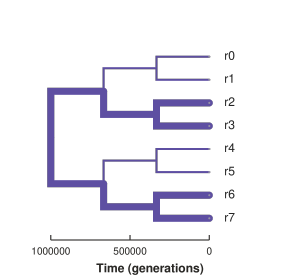

In [340]:
# VARY NE
# set parameters on the species tree
baltree_2_ne = BALTREE.copy()
# set root node dist value (node 14)
baltree_2_ne.set_node_data("dist", {14: 1e6/3}, inplace=True);

baltree_2_ne = baltree_2_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES2}, default=NE_DEFAULT)
baltree_2_ne = baltree_2_ne.set_node_data("gt", default=GT_DEFAULT)
baltree_2_ne = baltree_2_ne.set_node_data("tg", {i: i.dist / i.gt for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_2_ne})

# convert edge lens to units of generations.
baltree_2_ne = baltree_2_ne.set_node_data("dist", {i: i.tg for i in baltree_2_ne})

# show data
baltree_2_ne.get_node_data()

kwargs = dict(
    scale_bar=True, tip_labels_align=True, fixed_order = NAME_ORDER,
    edge_widths=("Ne", 2, 7), edge_colors="gt",
)

# canvas for tree
c, a, m = baltree_2_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
c

In [341]:
baltree_2_ne.write()

'(((r0:333333.333333,r1:333333.333333):333333.333333,(r2:333333.333333,r3:333333.333333):333333.333333):333333.333333,((r4:333333.333333,r5:333333.333333):333333.333333,(r6:333333.333333,r7:333333.333333):333333.333333):333333.333333):333333.333333;'

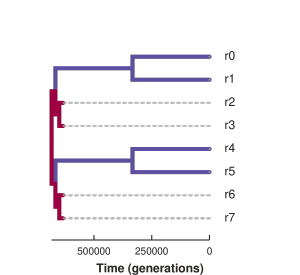

In [342]:
# VARY GT
baltree_2_gt = BALTREE.copy()
# set root node dist value (node 14)
baltree_2_gt.set_node_data("dist", {14: 1e6/3}, inplace=True);

baltree_2_gt = baltree_2_gt.set_node_data("Ne", default=NE_DEFAULT)
baltree_2_gt = baltree_2_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES2}, default=GT_DEFAULT)
baltree_2_gt = baltree_2_gt.set_node_data("tg", {i: i.dist / i.gt for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_2_gt})

# convert dist to units of generations. Draw and show data
baltree_2_gt = baltree_2_gt.set_node_data("dist", {i: i.tg for i in baltree_2_gt})
baltree_2_gt.get_node_data()

kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt", fixed_order=NAME_ORDER
)
c, a, m = baltree_2_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
c

In [343]:
baltree_2_gt.write()

'(((r0:333333.333333,r1:333333.333333):333333.333333,(r2:16666.6666667,r3:16666.6666667):16666.6666667):16666.6666667,((r4:333333.333333,r5:333333.333333):333333.333333,(r6:16666.6666667,r7:16666.6666667):16666.6666667):16666.6666667):333333.333333;'

### Input gene trees = 50,000 trees simulated in nb6

In [344]:
superset_rax_df_ne2_1e3 = pd.read_csv("./nb6_output/superset-rax-df-ne2-1e3.csv")
superset_rax_df_gt2_1e3 = pd.read_csv("./nb6_output/superset-rax-df-gt2-1e3.csv")
superset_rax_df_ne2_1e5 = pd.read_csv("./nb6_output/superset-rax-df-ne2-1e5.csv")
superset_rax_df_gt2_1e5 = pd.read_csv("./nb6_output/superset-rax-df-gt2-1e5.csv")
superset_rax_df_true_ne_unlinked = pd.read_csv("./nb6_output/superset-rax-df-true-ne-unlinked-bal.csv")
superset_rax_df_true_gt_unlinked = pd.read_csv("./nb6_output/superset-rax-df-true-gt-unlinked-bal.csv")
superset_rax_df_ne_concat_only = toytree.mtree("./nb6_output/superset-ne-concat-only-bal.nwk")
superset_rax_df_gt_concat_only = toytree.mtree("./nb6_output/superset-gt-concat-only-bal.nwk")

superset_rax_df_ne2_1e3.head()

Unnamed: 0  locus  start   end  nbps  nsnps                    gene_tree
0           0      0      0  1000  1000     77  ((r6:0.009843,(((r4:0.00...
1           1      1      0  1000  1000    110  ((r6:0.00909,((r0:0.0081...
2           2      2      0  1000  1000    120  (r6:0.016168,((r0:0.0119...
3           3      3      0  1000  1000    107  (r4:0.016555,(r7:0.02056...
4           4      4      0  1000  1000     83  ((r0:0.00314,r1:0.005049...

### Compute ASTRAL error rate for balanced tree scenario with QUARTETS

In [295]:
tree_test = toytree.rtree.baltree(8)
tree2_test = toytree.rtree.baltree(8)
qrt_test = toytree.distance.get_treedist_quartets(tree_test, tree2_test)
qrt_test

Q                              70.0
S                              70.0
D                               0.0
U                               0.0
R1                              0.0
R2                              0.0
N                              70.0
do_not_conflict                 0.0
explicitly_agree                0.0
strict_joint_assertions         0.0
semistrict_joint_assertions     0.0
steel_and_penny                 0.0
symmetric_difference            0.0
symmetric_divergence            1.0
similarity_to_reference         0.0
marczewski_steinhaus            0.0
dtype: float64

In [345]:
def astral_error_qrt(gtrees, correct_tree, gtrees_per_rep, reps):
    """Return error rate of astral inference."""
    # store output
    errors = []
    astral_trees = []
    qrts = []
    # for each replicate
    for i in range(reps):
        # sample 5000 gtrees each time
        sample_gtrees = np.random.choice(gtrees, gtrees_per_rep)
        # infer astral tree based on all inputted gtrees
        astral_tree = ipcoal.phylo.infer_astral_tree(trees = sample_gtrees)
        astral_trees.append(astral_tree.write())
        # check quartet (do not conflict) dist between astral and correct tree topology
        # 8 = DoNotConflict, 14 = similarity to reference
        qrt = toytree.distance.get_treedist_quartets(astral_tree, correct_tree)[14]
        qrts.append(qrt)
        # check if topology is correct or not
        if(qrt == 0):
            errors.append(0)
        else:
            errors.append(1)
    error_rate = sum(errors)/len(errors)
    
    # store output as data frame
    pd_data = {'astral_tree': astral_trees, 
               'qrt': qrts,
               'error_binary': errors,
              } 
    df_out = pd.DataFrame(data=pd_data)  

    return error_rate, df_out

#### astral_raxml_ne_1e3 (Ne, nsites=1e3)

In [346]:
error_rate_ne2_1e3_qrt, df_out_ne2_1e3_qrt = astral_error_qrt(superset_rax_df_ne2_1e3.gene_tree, baltree_2_ne, 5000, 100)

In [347]:
error_rate_ne2_1e3_qrt

0.04

In [348]:
df_out_ne2_1e3_qrt.to_csv("./nb7_output/astral_error_ne2_1e3_qrt.csv")

In [349]:
df_out_ne2_1e3_qrt

astral_tree  qrt  error_binary
0   (r6:1,(r7:1,((r4:1,r5:1)...  0.0             0
1   (r2:1,(r3:1,(((r4:1,r5:1...  0.0             0
2   (r0:1,(r1:1,(((r5:1,r4:1...  0.0             0
3   (r5:1,(r4:1,(((r1:1,r0:1...  0.0             0
4   (r7:1,(r6:1,(((r2:1,r3:1...  0.0             0
..                          ...  ...           ...
95  (r4:1,(r5:1,((r7:1,r6:1)...  0.0             0
96  (r7:1,(r6:1,((r4:1,r5:1)...  0.0             0
97  (r4:1,(r5:1,((r6:1,r7:1)...  0.0             0
98  (r3:1,(r2:1,(((r6:1,r7:1...  0.0             0
99  (r6:1,(r7:1,((r4:1,r5:1)...  0.0             0

[100 rows x 3 columns]

#### astral_raxml_tg_1e3 (gt, nsites=1e3)

In [350]:
error_rate_gt2_1e3_qrt, df_out_gt2_1e3_qrt = astral_error_qrt(superset_rax_df_gt2_1e3.gene_tree, baltree_2_gt, 5000, 100)

In [351]:
error_rate_gt2_1e3_qrt

0.14

In [352]:
df_out_gt2_1e3_qrt.to_csv("./nb7_output/astral_error_gt2_1e3_qrt.csv")

In [353]:
df_out_gt2_1e3_qrt

astral_tree       qrt  error_binary
0   (r6:1,(r7:1,((r4:1,r5:1)...  0.000000             0
1   (r4:1,(((r6:1,r7:1)0.73:...  0.000000             0
2   (r1:1,(((r3:1,r2:1)0.87:...  0.000000             0
3   (r6:1,(r7:1,((r4:1,r5:1)...  0.000000             0
4   (r4:1,(((r6:1,r7:1)0.79:...  0.114286             1
..                          ...       ...           ...
95  (r0:1,(((r2:1,r3:1)0.82:...  0.000000             0
96  (r2:1,(r3:1,((r0:1,r1:1)...  0.000000             0
97  (r7:1,(r6:1,((r5:1,r4:1)...  0.000000             0
98  (r5:1,(r4:1,((r6:1,r7:1)...  0.000000             0
99  (r7:1,(r6:1,((r5:1,r4:1)...  0.114286             1

[100 rows x 3 columns]

#### astral_raxml_ne_1e5 (Ne, nsites=1e5)

In [354]:
error_rate_ne2_1e5_qrt,  df_out_ne2_1e5_qrt = astral_error_qrt(superset_rax_df_ne2_1e5.gene_tree, baltree_2_ne, 5000, 100)

In [355]:
error_rate_ne2_1e5_qrt

0.0

In [356]:
df_out_ne2_1e5_qrt.to_csv("./nb7_output/astral_error_ne2_1e5_qrt.csv")

In [357]:
df_out_ne2_1e5_qrt

astral_tree  qrt  error_binary
0   (r2:1,(((r0:1,r1:1)1:4.0...  0.0             0
1   (r0:1,(((r3:1,r2:1)1:0.1...  0.0             0
2   (r7:1,(((r4:1,r5:1)1:3.7...  0.0             0
3   (r2:1,(r3:1,((r0:1,r1:1)...  0.0             0
4   (r5:1,(((r7:1,r6:1)1:0.1...  0.0             0
..                          ...  ...           ...
95  (r1:1,(((r2:1,r3:1)1:0.1...  0.0             0
96  (r3:1,(r2:1,((r0:1,r1:1)...  0.0             0
97  (r0:1,(((r3:1,r2:1)1:0.1...  0.0             0
98  (r0:1,(((r2:1,r3:1)1:0.1...  0.0             0
99  (r3:1,(r2:1,((r0:1,r1:1)...  0.0             0

[100 rows x 3 columns]

#### astral_raxml_tg_1e5 (gt, nsites=1e5)

In [358]:
error_rate_gt2_1e5_qrt, df_out_gt2_1e5_qrt = astral_error_qrt(superset_rax_df_gt2_1e5.gene_tree, baltree_2_gt, 5000, 100)

In [359]:
error_rate_gt2_1e5_qrt

0.0

In [360]:
df_out_gt2_1e5_qrt.to_csv("./nb7_output/astral_error_gt2_1e5_qrt.csv")

In [361]:
df_out_gt2_1e5_qrt

astral_tree  qrt  error_binary
0   (r6:1,(r7:1,((r4:1,r5:1)...  0.0             0
1   (r1:1,(((r3:1,r2:1)1:0.0...  0.0             0
2   (r5:1,(((r6:1,r7:1)1:0.0...  0.0             0
3   (r1:1,(((r3:1,r2:1)1:0.0...  0.0             0
4   (r6:1,(((r4:1,r5:1)1:1.8...  0.0             0
..                          ...  ...           ...
95  (r4:1,(((r6:1,r7:1)1:0.0...  0.0             0
96  (r0:1,(r1:1,(((r5:1,r4:1...  0.0             0
97  (r2:1,(((r0:1,r1:1)1:1.8...  0.0             0
98  (r0:1,(((r3:1,r2:1)1:0.0...  0.0             0
99  (r6:1,(r7:1,(((r3:1,r2:1...  0.0             0

[100 rows x 3 columns]

#### astral_true_ne (true unlinked Ne)

In [362]:
error_rate_ne_true_qrt, df_out_ne_true_qrt = astral_error_qrt(superset_rax_df_true_ne_unlinked.genealogy, baltree_2_ne, 5000, 100)
error_rate_ne_true_qrt

0.2

In [363]:
df_out_ne_true_qrt.to_csv("./nb7_output/astral_error_ne_true_qrt.csv")

In [364]:
df_out_ne_true_qrt

astral_tree       qrt  error_binary
0   (r4:1,(r5:1,(((r0:1,r1:1...  0.000000             0
1   (r0:1,(((r2:1,r3:1)0.99:...  0.000000             0
2   (r1:1,(r0:1,((r6:1,(r7:1...  0.114286             1
3   (r5:1,(r4:1,((r3:1,(r2:1...  0.114286             1
4   (r7:1,(r6:1,(((r0:1,r1:1...  0.000000             0
..                          ...       ...           ...
95  (r2:1,(r3:1,((r0:1,r1:1)...  0.000000             0
96  (r3:1,(r2:1,(((r6:1,r7:1...  0.000000             0
97  (r7:1,(r6:1,((r4:1,r5:1)...  0.000000             0
98  (r0:1,(r1:1,(r2:1,(r3:1,...  0.114286             1
99  (r6:1,(r7:1,((r4:1,r5:1)...  0.000000             0

[100 rows x 3 columns]

#### astral_true_tg (true unlinked tg)

In [365]:
error_rate_gt_true_qrt, df_out_gt_true_qrt = astral_error_qrt(superset_rax_df_true_gt_unlinked.genealogy, baltree_2_gt, 5000, 100)
error_rate_gt_true_qrt

0.16

In [366]:
df_out_gt_true_qrt.to_csv("./nb7_output/astral_error_gt_true_qrt.csv")

In [367]:
df_out_gt_true_qrt

astral_tree       qrt  error_binary
0   (r7:1,(r6:1,(((r3:1,r2:1...  0.000000             0
1   (r3:1,(r2:1,((r0:1,r1:1)...  0.000000             0
2   (r4:1,(r5:1,(((r3:1,r2:1...  0.000000             0
3   (r7:1,(r6:1,(((r3:1,r2:1...  0.000000             0
4   (r2:1,((r0:1,r1:1)1:0.31...  0.114286             1
..                          ...       ...           ...
95  (r5:1,(((r7:1,r6:1)0.82:...  0.000000             0
96  (r0:1,(r1:1,((r2:1,r3:1)...  0.114286             1
97  (r1:1,(r0:1,((r2:1,r3:1)...  0.000000             0
98  (r2:1,(r3:1,(((r6:1,r7:1...  0.000000             0
99  (r0:1,(r1:1,((r2:1,r3:1)...  0.000000             0

[100 rows x 3 columns]

#### concat only Ne

In [368]:
error_rate_ne_concat_only_qrt, df_out_ne_concat_only_qrt = astral_error_qrt(superset_rax_df_ne_concat_only, baltree_2_ne, 5000, 100)
error_rate_ne_concat_only_qrt

0.0

In [369]:
df_out_ne_concat_only_qrt.to_csv("./nb7_output/astral_error_ne_concat_only_qrt.csv")

In [370]:
df_out_ne_concat_only_qrt

astral_tree  qrt  error_binary
0   (r0:1,(((r2:1,r3:1)1:8.1...  0.0             0
1   (r2:1,(((r0:1,r1:1)1:8.1...  0.0             0
2   (r3:1,(r2:1,((r0:1,r1:1)...  0.0             0
3   (r0:1,(((r3:1,r2:1)1:8.1...  0.0             0
4   (r0:1,(((r2:1,r3:1)1:8.1...  0.0             0
..                          ...  ...           ...
95  (r0:1,(((r2:1,r3:1)1:8.1...  0.0             0
96  (r4:1,(((r6:1,r7:1)1:8.1...  0.0             0
97  (r5:1,(((r7:1,r6:1)1:8.1...  0.0             0
98  (r3:1,(r2:1,((r0:1,r1:1)...  0.0             0
99  (r5:1,(((r7:1,r6:1)1:8.1...  0.0             0

[100 rows x 3 columns]

#### concat only gt

In [371]:
error_rate_gt_concat_only_qrt, df_out_gt_concat_only_qrt = astral_error_qrt(superset_rax_df_gt_concat_only, baltree_2_gt, 5000, 100)
error_rate_gt_concat_only_qrt

0.0

In [372]:
df_out_gt_concat_only_qrt.to_csv("./nb7_output/astral_error_gt_concat_only_qrt.csv")

In [373]:
df_out_gt_concat_only_qrt

astral_tree  qrt  error_binary
0   (r5:1,(((r6:1,r7:1)1:8.1...  0.0             0
1   (r7:1,(((r4:1,r5:1)1:8.1...  0.0             0
2   (r3:1,(r2:1,(((r7:1,r6:1...  0.0             0
3   (r1:1,(((r3:1,r2:1)1:8.1...  0.0             0
4   (r3:1,(r2:1,((r0:1,r1:1)...  0.0             0
..                          ...  ...           ...
95  (r4:1,(r5:1,(((r0:1,r1:1...  0.0             0
96  (r3:1,(r2:1,((r0:1,r1:1)...  0.0             0
97  (r5:1,(((r7:1,r6:1)1:8.1...  0.0             0
98  (r6:1,(r7:1,((r5:1,r4:1)...  0.0             0
99  (r3:1,(r2:1,((r0:1,r1:1)...  0.0             0

[100 rows x 3 columns]

### Balanced tree scenario ASTRAL error rate plot with QUARTETS

In [374]:
# color palette
colors = toyplot.color.brewer.palette("Set2")

In [375]:
# error rates RELAX
data_qrt = np.array([error_rate_ne_concat_only_qrt, error_rate_gt_concat_only_qrt, 
                 error_rate_ne_true_qrt, error_rate_gt_true_qrt, 
                 error_rate_ne2_1e3_qrt, error_rate_gt2_1e3_qrt,
                 error_rate_gt2_1e3_qrt, error_rate_gt2_1e5_qrt])
data_qrt

array([0.  , 0.  , 0.2 , 0.16, 0.04, 0.14, 0.14, 0.  ])

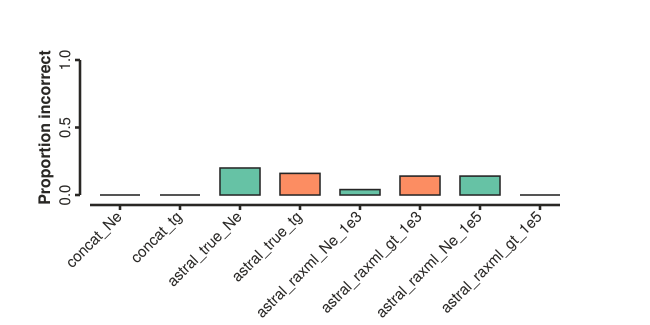

In [376]:
canvas = toyplot.Canvas(width=650, height=325)
axes = canvas.cartesian(bounds=(80, -80, 50, -120))
axes.x.ticks.locator = toyplot.locator.Explicit(np.arange(data_qrt.size) + 0.5, )
axes.x.spine.style["stroke-width"] = 2.5
axes.x.ticks.style["stroke-width"] = 2.5
axes.x.ticks.labels.style["font-size"] = 15
axes.x.label.style["font-size"] = 16
axes.x.domain.min = 0
axes.x.ticks.locator = toyplot.locator.Explicit(
    locations=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
    labels=["concat_Ne", "concat_tg", "astral_true_Ne", "astral_true_tg", "astral_raxml_Ne_1e3", "astral_raxml_gt_1e3", "astral_raxml_Ne_1e5", "astral_raxml_gt_1e5"])
axes.x.ticks.labels.angle = 45

axes.y.label.text = "Proportion incorrect"
axes.y.spine.style["stroke-width"] = 2.5
axes.y.ticks.style["stroke-width"] = 2.5
axes.y.ticks.labels.style["font-size"] = 15
axes.y.ticks.labels.style["font-size"] = 15
axes.y.label.style["font-size"] = 16
axes.y.domain.max = 1.0

starts = np.arange(data_qrt.size) + 1/6
mark = axes.bars(
    starts, 
    starts + 4/6,
    data_qrt,
    style={"stroke": "#262626", 
           "stroke-width": 1.5},
    color=[colors[0], colors[1], colors[0], colors[1], colors[0], colors[1], colors[0], colors[1]]
)

toytree.utils.set_axes_ticks_external(axes);
toyplot.svg.render(canvas, "./nb7_output/astral-error-rate-plot-qrt.svg")
canvas

### Compute ASTRAL error rate for balanced tree scenario with RFG-MCI

In [377]:
def astral_error_rfg_mci(gtrees, correct_tree, gtrees_per_rep, reps, relax=False):
    """Return error rate of astral inference."""
    # store output
    errors = []
    astral_trees = []
    rfg_mcis = []
    # for each replicate
    for i in range(reps):
        # sample 5000 gtrees each time
        sample_gtrees = np.random.choice(gtrees, gtrees_per_rep)
        # infer astral tree based on all inputted gtrees
        astral_tree = ipcoal.phylo.infer_astral_tree(trees = sample_gtrees)
        astral_trees.append(astral_tree.write())
        # check rfg_mci dist between astral and correct tree topology
        rfg_mci = toytree.distance.get_treedist_rfg_mci(astral_tree, correct_tree)
        rfg_mcis.append(rfg_mci)
        # check if topology is correct or not
        if(relax==False):
            if(np.allclose(rfg_mci,0) == True):
                errors.append(0)
            else:
                errors.append(1)
        else:
            if(rfg_mci == 0):
                errors.append(0)
            else:
                errors.append(1)
    error_rate = sum(errors)/len(errors)
    
    # store output as data frame
    pd_data = {'astral_tree': astral_trees, 
               'rfg_mci': rfg_mcis,
               'error_binary': errors,
              } 
    df_out = pd.DataFrame(data=pd_data)  

    return error_rate, df_out

#### astral_raxml_ne_1e3 (Ne, nsites=1e3)

In [378]:
error_rate_ne2_1e3_rfg_mci, df_out_ne2_1e3_rfg_mci = astral_error_rfg_mci(superset_rax_df_ne2_1e3.gene_tree, baltree_2_ne, 5000, 100)

In [379]:
error_rate_ne2_1e3_rfg_mci

0.04

In [380]:
df_out_ne2_1e3_rfg_mci.to_csv("./nb7_output/astral_error_ne2_1e3_rfg_mci.csv")

In [381]:
df_out_ne2_1e3_rfg_mci

astral_tree       rfg_mci  error_binary
0   (r5:1,(r4:1,((r7:1,r6:1)...  1.734288e+00             1
1   (r2:1,(r3:1,((r0:1,r1:1)...  1.776357e-15             0
2   (r0:1,(r1:1,((r3:1,r2:1)...  1.776357e-15             0
3   (r5:1,(r4:1,((r6:1,r7:1)...  1.776357e-15             0
4   (r3:1,(r2:1,((r1:1,r0:1)...  1.776357e-15             0
..                          ...           ...           ...
95  (r6:1,(r7:1,((r5:1,r4:1)...  1.776357e-15             0
96  (r6:1,(((r5:1,r4:1)1:0.3...  1.776357e-15             0
97  (r0:1,(((r3:1,r2:1)0.94:...  1.776357e-15             0
98  (r1:1,(((r2:1,r3:1)1:0.0...  1.776357e-15             0
99  (r3:1,(r2:1,((r0:1,r1:1)...  1.776357e-15             0

[100 rows x 3 columns]

In [382]:
error_rate_ne2_1e3_rfg_mci_relax, df_out_ne2_1e3_rfg_mci_relax = astral_error_rfg_mci(superset_rax_df_ne2_1e3.gene_tree, baltree_2_ne, 5000, 100, True)

In [383]:
error_rate_ne2_1e3_rfg_mci_relax

0.8

In [384]:
df_out_ne2_1e3_rfg_mci_relax.to_csv("./nb7_output/astral_error_ne2_1e3_rfg_mci_relax.csv")

#### astral_raxml_tg_1e3 (gt, nsites=1e3)

In [385]:
error_rate_gt2_1e3_rfg_mci, df_out_gt2_1e3_rfg_mci = astral_error_rfg_mci(superset_rax_df_gt2_1e3.gene_tree, baltree_2_gt, 5000, 100)

In [386]:
error_rate_gt2_1e3_rfg_mci

0.12

In [387]:
df_out_gt2_1e3_rfg_mci.to_csv("./nb7_output/astral_error_gt2_1e3_rfg_mci.csv")

In [388]:
df_out_gt2_1e3_rfg_mci

astral_tree       rfg_mci  error_binary
0   (r3:1,((r0:1,r1:1)1:0.33...  1.734288e+00             1
1   (r3:1,(r2:1,((r0:1,r1:1)...  1.734288e+00             1
2   (r3:1,(((r0:1,r1:1)1:0.3...  1.776357e-15             0
3   (r0:1,(((r3:1,r2:1)0.76:...  1.776357e-15             0
4   (r0:1,(r1:1,((r2:1,r3:1)...  1.776357e-15             0
..                          ...           ...           ...
95  (r4:1,(((r6:1,r7:1)0.88:...  1.776357e-15             0
96  (r1:1,(((r2:1,r3:1)0.93:...  1.776357e-15             0
97  (r0:1,(r1:1,((r2:1,r3:1)...  1.776357e-15             0
98  (r1:1,(((r2:1,r3:1)0.97:...  1.734288e+00             1
99  (r6:1,(r7:1,((r5:1,r4:1)...  1.776357e-15             0

[100 rows x 3 columns]

In [389]:
error_rate_gt2_1e3_rfg_mci_relax, df_out_gt2_1e3_rfg_mci_relax = astral_error_rfg_mci(superset_rax_df_gt2_1e3.gene_tree, baltree_2_gt, 5000, 100, True)

In [390]:
error_rate_gt2_1e3_rfg_mci_relax

0.77

In [391]:
df_out_gt2_1e3_rfg_mci_relax.to_csv("./nb7_output/astral_error_gt2_1e3_rfg_mci_relax.csv")

#### astral_raxml_ne_1e5 (Ne, nsites=1e5)

In [392]:
error_rate_ne2_1e5_rfg_mci,  df_out_ne2_1e5_rfg_mci = astral_error_rfg_mci(superset_rax_df_ne2_1e5.gene_tree, baltree_2_ne, 5000, 100)

In [393]:
error_rate_ne2_1e5_rfg_mci

0.0

In [394]:
df_out_ne2_1e5_rfg_mci.to_csv("./nb7_output/astral_error_ne2_1e5_rfg_mci.csv")

In [395]:
df_out_ne2_1e5_rfg_mci

astral_tree       rfg_mci  error_binary
0   (r6:1,(((r4:1,r5:1)1:3.8...  1.776357e-15             0
1   (r4:1,(((r7:1,r6:1)1:0.1...  1.776357e-15             0
2   (r7:1,(((r4:1,r5:1)1:3.8...  1.776357e-15             0
3   (r3:1,(r2:1,(((r5:1,r4:1...  0.000000e+00             0
4   (r4:1,(((r7:1,r6:1)1:0.1...  1.776357e-15             0
..                          ...           ...           ...
95  (r0:1,(((r3:1,r2:1)1:0.1...  1.776357e-15             0
96  (r2:1,(r3:1,((r0:1,r1:1)...  1.776357e-15             0
97  (r5:1,(((r6:1,r7:1)1:0.1...  1.776357e-15             0
98  (r1:1,(((r2:1,r3:1)1:0.1...  1.776357e-15             0
99  (r1:1,(((r2:1,r3:1)1:0.1...  1.776357e-15             0

[100 rows x 3 columns]

In [396]:
error_rate_ne2_1e5_rfg_mci_relax, df_out_ne2_1e5_rfg_mci_relax = astral_error_rfg_mci(superset_rax_df_ne2_1e5.gene_tree, baltree_2_ne, 5000, 100, True)

In [397]:
error_rate_ne2_1e5_rfg_mci_relax

0.77

In [398]:
df_out_ne2_1e5_rfg_mci_relax.to_csv("./nb7_output/astral_error_ne2_1e5_rfg_mci_relax.csv")

#### astral_raxml_tg_1e5 (gt, nsites=1e5)

In [399]:
error_rate_gt2_1e5_rfg_mci, df_out_gt2_1e5_rfg_mci = astral_error_rfg_mci(superset_rax_df_gt2_1e5.gene_tree, baltree_2_gt, 5000, 100)

In [400]:
error_rate_gt2_1e5_rfg_mci

0.0

In [401]:
df_out_gt2_1e5_rfg_mci.to_csv("./nb7_output/astral_error_gt2_1e5_rfg_mci.csv")

In [402]:
df_out_gt2_1e5_rfg_mci

astral_tree       rfg_mci  error_binary
0   (r0:1,(((r3:1,r2:1)1:0.0...  1.776357e-15             0
1   (r2:1,(r3:1,(((r6:1,r7:1...  0.000000e+00             0
2   (r2:1,(r3:1,(((r7:1,r6:1...  0.000000e+00             0
3   (r2:1,(r3:1,((r1:1,r0:1)...  1.776357e-15             0
4   (r4:1,(((r6:1,r7:1)1:0.0...  1.776357e-15             0
..                          ...           ...           ...
95  (r6:1,(((r4:1,r5:1)1:1.7...  1.776357e-15             0
96  (r1:1,(r0:1,(((r7:1,r6:1...  0.000000e+00             0
97  (r7:1,(((r5:1,r4:1)1:1.8...  1.776357e-15             0
98  (r3:1,(r2:1,(((r7:1,r6:1...  0.000000e+00             0
99  (r5:1,(r4:1,((r7:1,r6:1)...  1.776357e-15             0

[100 rows x 3 columns]

In [403]:
error_rate_gt2_1e5_rfg_mci_relax, df_out_gt2_1e5_rfg_mci_relax = astral_error_rfg_mci(superset_rax_df_gt2_1e5.gene_tree, baltree_2_gt, 5000, 100, True)

In [404]:
error_rate_gt2_1e5_rfg_mci_relax

0.85

In [405]:
df_out_gt2_1e5_rfg_mci_relax.to_csv("./nb7_output/astral_error_gt2_1e5_rfg_mci_relax.csv")

#### astral_true_ne (true unlinked Ne)

In [406]:
error_rate_ne_true_rfg_mci, df_out_ne_true_rfg_mci = astral_error_rfg_mci(superset_rax_df_true_ne_unlinked.genealogy, baltree_2_ne, 5000, 100)
error_rate_ne_true_rfg_mci

0.23

In [407]:
df_out_ne_true_rfg_mci.to_csv("./nb7_output/astral_error_gt_true_rfg_mci.csv")

In [408]:
df_out_ne_true_rfg_mci

astral_tree       rfg_mci  error_binary
0   (r7:1,((r6:1,(r4:1,r5:1)...  1.734288e+00             1
1   (r2:1,(r3:1,((r0:1,r1:1)...  1.776357e-15             0
2   (r1:1,(r0:1,((r7:1,(r6:1...  1.734288e+00             1
3   (r2:1,(r3:1,((r0:1,r1:1)...  1.776357e-15             0
4   (r4:1,(((r6:1,r7:1)0.5:0...  1.776357e-15             0
..                          ...           ...           ...
95  (r4:1,(r5:1,((r6:1,r7:1)...  1.776357e-15             0
96  (r4:1,(r5:1,((r7:1,r6:1)...  1.776357e-15             0
97  (r1:1,(r0:1,(r3:1,(r2:1,...  1.734288e+00             1
98  (r1:1,(r0:1,(((r4:1,r5:1...  0.000000e+00             0
99  (r4:1,(r5:1,(((r0:1,r1:1...  0.000000e+00             0

[100 rows x 3 columns]

In [409]:
error_rate_ne_true_rfg_mci_relax, df_out_ne_true_rfg_mci_relax = astral_error_rfg_mci(superset_rax_df_true_ne_unlinked.genealogy, baltree_2_ne, 5000, 100, True)

In [410]:
error_rate_ne_true_rfg_mci_relax

0.74

In [411]:
df_out_ne_true_rfg_mci_relax.to_csv("./nb7_output/astral_error_ne_true_rfg_mci_relax.csv")

#### astral_true_tg (true unlinked tg)

In [412]:
error_rate_gt_true_rfg_mci, df_out_gt_true_rfg_mci = astral_error_rfg_mci(superset_rax_df_true_gt_unlinked.genealogy, baltree_2_gt, 5000, 100)
error_rate_gt_true_rfg_mci

0.18

In [413]:
df_out_gt_true_rfg_mci.to_csv("./nb7_output/astral_error_gt_true_rfg_mci.csv")

In [414]:
df_out_gt_true_rfg_mci

astral_tree       rfg_mci  error_binary
0   (r7:1,(r6:1,((r5:1,r4:1)...  1.776357e-15             0
1   (r0:1,(r1:1,((r3:1,r2:1)...  1.776357e-15             0
2   (r7:1,(r6:1,((r4:1,r5:1)...  1.776357e-15             0
3   (r4:1,(r5:1,(((r2:1,r3:1...  0.000000e+00             0
4   (r0:1,(r1:1,(((r7:1,r6:1...  0.000000e+00             0
..                          ...           ...           ...
95  (r2:1,(r3:1,((r0:1,r1:1)...  1.776357e-15             0
96  (r3:1,(r2:1,((r0:1,r1:1)...  1.776357e-15             0
97  (r4:1,(r5:1,(((r2:1,r3:1...  0.000000e+00             0
98  (r3:1,(r2:1,(((r5:1,r4:1...  0.000000e+00             0
99  (r0:1,(((r3:1,r2:1)0.93:...  1.776357e-15             0

[100 rows x 3 columns]

In [415]:
error_rate_gt_true_rfg_mci_relax, df_out_gt_true_rfg_mci_relax = astral_error_rfg_mci(superset_rax_df_true_gt_unlinked.genealogy, baltree_2_gt, 5000, 100, True)
error_rate_gt_true_rfg_mci_relax

0.85

In [416]:
df_out_gt_true_rfg_mci_relax.to_csv("./nb7_output/astral_error_gt_true_rfg_mci_relax.csv")

In [417]:
df_out_gt_true_rfg_mci_relax

astral_tree       rfg_mci  error_binary
0   (r4:1,(((r7:1,r6:1)0.76:...  1.776357e-15             1
1   (r7:1,(((r0:1,r1:1)1:0.3...  1.734288e+00             1
2   (r2:1,(r3:1,((r1:1,r0:1)...  1.776357e-15             1
3   (r7:1,(r6:1,((r4:1,r5:1)...  1.776357e-15             1
4   (r3:1,(r2:1,((r0:1,r1:1)...  1.776357e-15             1
..                          ...           ...           ...
95  (r1:1,(((r2:1,r3:1)0.78:...  1.776357e-15             1
96  (r4:1,(r5:1,((r7:1,r6:1)...  1.776357e-15             1
97  (r0:1,(r1:1,(((r6:1,r7:1...  0.000000e+00             0
98  (r3:1,(r2:1,((r0:1,r1:1)...  1.734288e+00             1
99  (r0:1,(((r3:1,r2:1)0.99:...  1.776357e-15             1

[100 rows x 3 columns]

#### concat only Ne

In [418]:
error_rate_ne_concat_only_rfg_mci, df_out_ne_concat_only_rfg_mci = astral_error_rfg_mci(superset_rax_df_ne_concat_only, baltree_2_ne, 5000, 100)
error_rate_ne_concat_only_rfg_mci

0.0

In [419]:
df_out_ne_concat_only_rfg_mci.to_csv("./nb7_output/astral_error_ne_concat_only_rfg_mci.csv")

In [420]:
df_out_ne_concat_only_rfg_mci

astral_tree       rfg_mci  error_binary
0   (r5:1,(((r7:1,r6:1)1:8.1...  1.776357e-15             0
1   (r2:1,(r3:1,((r0:1,r1:1)...  1.776357e-15             0
2   (r7:1,(((r5:1,r4:1)1:8.1...  1.776357e-15             0
3   (r3:1,(r2:1,(((r6:1,r7:1...  0.000000e+00             0
4   (r7:1,(r6:1,((r4:1,r5:1)...  1.776357e-15             0
..                          ...           ...           ...
95  (r4:1,(((r6:1,r7:1)1:8.1...  1.776357e-15             0
96  (r1:1,(((r2:1,r3:1)1:8.1...  1.776357e-15             0
97  (r7:1,(((r5:1,r4:1)1:8.1...  1.776357e-15             0
98  (r6:1,(((r5:1,r4:1)1:8.1...  1.776357e-15             0
99  (r1:1,(((r3:1,r2:1)1:8.1...  1.776357e-15             0

[100 rows x 3 columns]

In [421]:
error_rate_ne_concat_only_rfg_mci_relax, df_out_ne_concat_only_rfg_mci_relax = astral_error_rfg_mci(superset_rax_df_ne_concat_only, baltree_2_ne, 5000, 100, True)
error_rate_ne_concat_only_rfg_mci_relax

0.93

In [422]:
df_out_ne_concat_only_rfg_mci_relax.to_csv("./nb7_output/astral_error_ne_concat_only_rfg_mci_relax.csv")

In [423]:
df_out_ne_concat_only_rfg_mci_relax

astral_tree       rfg_mci  error_binary
0   (r7:1,(((r5:1,r4:1)1:8.1...  1.776357e-15             1
1   (r7:1,(((r4:1,r5:1)1:8.1...  1.776357e-15             1
2   (r3:1,(((r0:1,r1:1)1:8.1...  1.776357e-15             1
3   (r6:1,(((r5:1,r4:1)1:8.1...  1.776357e-15             1
4   (r1:1,(((r2:1,r3:1)1:8.1...  1.776357e-15             1
..                          ...           ...           ...
95  (r4:1,(((r6:1,r7:1)1:8.1...  1.776357e-15             1
96  (r3:1,(r2:1,((r0:1,r1:1)...  1.776357e-15             1
97  (r3:1,(((r0:1,r1:1)1:8.1...  1.776357e-15             1
98  (r7:1,(((r5:1,r4:1)1:8.1...  1.776357e-15             1
99  (r6:1,(r7:1,(((r0:1,r1:1...  0.000000e+00             0

[100 rows x 3 columns]

#### concat only gt

In [424]:
error_rate_gt_concat_only_rfg_mci, df_out_gt_concat_only_rfg_mci = astral_error_rfg_mci(superset_rax_df_gt_concat_only, baltree_2_gt, 5000, 100)
error_rate_gt_concat_only_rfg_mci

0.0

In [425]:
df_out_gt_concat_only_rfg_mci.to_csv("./nb7_output/astral_error_gt_concat_only_rfg_mci.csv")

In [426]:
df_out_gt_concat_only_rfg_mci

astral_tree       rfg_mci  error_binary
0   (r6:1,(r7:1,(((r0:1,r1:1...  0.000000e+00             0
1   (r4:1,(((r6:1,r7:1)1:8.1...  1.776357e-15             0
2   (r5:1,(((r6:1,r7:1)1:8.1...  1.776357e-15             0
3   (r2:1,(r3:1,(((r6:1,r7:1...  0.000000e+00             0
4   (r7:1,(((r5:1,r4:1)1:8.1...  1.776357e-15             0
..                          ...           ...           ...
95  (r5:1,(((r7:1,r6:1)1:8.1...  1.776357e-15             0
96  (r0:1,(((r2:1,r3:1)1:8.1...  1.776357e-15             0
97  (r3:1,(((r1:1,r0:1)1:8.1...  1.776357e-15             0
98  (r6:1,(((r4:1,r5:1)1:8.1...  1.776357e-15             0
99  (r0:1,(((r3:1,r2:1)1:8.1...  1.776357e-15             0

[100 rows x 3 columns]

In [427]:
error_rate_gt_concat_only_rfg_mci_relax, df_out_gt_concat_only_rfg_mci_relax = astral_error_rfg_mci(superset_rax_df_gt_concat_only, baltree_2_gt, 5000, 100, True)
error_rate_gt_concat_only_rfg_mci_relax

0.88

In [428]:
df_out_gt_concat_only_rfg_mci_relax.to_csv("./nb7_output/astral_error_gt_concat_only_rfg_mci_relax.csv")

In [429]:
df_out_gt_concat_only_rfg_mci_relax

astral_tree       rfg_mci  error_binary
0   (r2:1,(r3:1,(((r6:1,r7:1...  0.000000e+00             0
1   (r6:1,(((r5:1,r4:1)1:8.1...  1.776357e-15             1
2   (r6:1,(((r4:1,r5:1)1:8.1...  1.776357e-15             1
3   (r3:1,(r2:1,((r0:1,r1:1)...  1.776357e-15             1
4   (r6:1,(((r4:1,r5:1)1:8.1...  1.776357e-15             1
..                          ...           ...           ...
95  (r5:1,(((r6:1,r7:1)1:8.1...  1.776357e-15             1
96  (r3:1,(((r1:1,r0:1)1:8.1...  1.776357e-15             1
97  (r0:1,(((r3:1,r2:1)1:8.1...  1.776357e-15             1
98  (r1:1,(((r2:1,r3:1)1:8.1...  1.776357e-15             1
99  (r7:1,(r6:1,((r4:1,r5:1)...  1.776357e-15             1

[100 rows x 3 columns]

### Balanced tree scenario ASTRAL error rate plot with RFG-MCI

In [430]:
# color palette
colors = toyplot.color.brewer.palette("Set2")

In [431]:
# error rates
data_rfg_mci = np.array([error_rate_ne_concat_only_rfg_mci, error_rate_gt_concat_only_rfg_mci, 
                 error_rate_ne_true_rfg_mci, error_rate_gt_true_rfg_mci, 
                 error_rate_ne2_1e3_rfg_mci, error_rate_gt2_1e3_rfg_mci,
                 error_rate_gt2_1e3_rfg_mci, error_rate_gt2_1e5_rfg_mci])
data_rfg_mci

array([0.  , 0.  , 0.23, 0.18, 0.04, 0.12, 0.12, 0.  ])

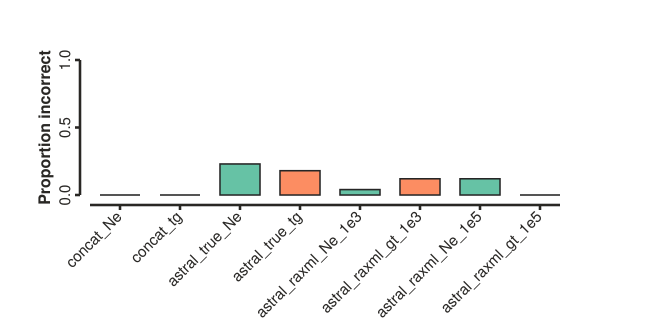

In [432]:
canvas = toyplot.Canvas(width=650, height=325)
axes = canvas.cartesian(bounds=(80, -80, 50, -120))
axes.x.ticks.locator = toyplot.locator.Explicit(np.arange(data_rfg_mci.size) + 0.5, )
axes.x.spine.style["stroke-width"] = 2.5
axes.x.ticks.style["stroke-width"] = 2.5
axes.x.ticks.labels.style["font-size"] = 15
axes.x.label.style["font-size"] = 16
axes.x.domain.min = 0
axes.x.ticks.locator = toyplot.locator.Explicit(
    locations=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
    labels=["concat_Ne", "concat_tg", "astral_true_Ne", "astral_true_tg", "astral_raxml_Ne_1e3", "astral_raxml_gt_1e3", "astral_raxml_Ne_1e5", "astral_raxml_gt_1e5"])
axes.x.ticks.labels.angle = 45

axes.y.label.text = "Proportion incorrect"
axes.y.spine.style["stroke-width"] = 2.5
axes.y.ticks.style["stroke-width"] = 2.5
axes.y.ticks.labels.style["font-size"] = 15
axes.y.ticks.labels.style["font-size"] = 15
axes.y.label.style["font-size"] = 16
axes.y.domain.max = 1.0

starts = np.arange(data_rfg_mci.size) + 1/6
mark = axes.bars(
    starts, 
    starts + 4/6,
    data_rfg_mci,
    style={"stroke": "#262626", 
           "stroke-width": 1.5},
    color=[colors[0], colors[1], colors[0], colors[1], colors[0], colors[1], colors[0], colors[1]]
)

toytree.utils.set_axes_ticks_external(axes);
toyplot.svg.render(canvas, "./nb7_output/astral-error-rate-plot-rfg-mci-rounded.svg")
canvas

In [433]:
# error rates RELAX
data_rfg_mci_relax = np.array([error_rate_ne_concat_only_rfg_mci_relax, error_rate_gt_concat_only_rfg_mci_relax, 
                 error_rate_ne_true_rfg_mci_relax, error_rate_gt_true_rfg_mci_relax, 
                 error_rate_ne2_1e3_rfg_mci_relax, error_rate_gt2_1e3_rfg_mci_relax,
                 error_rate_gt2_1e3_rfg_mci_relax, error_rate_gt2_1e5_rfg_mci_relax])
data_rfg_mci_relax

array([0.93, 0.88, 0.74, 0.85, 0.8 , 0.77, 0.77, 0.85])

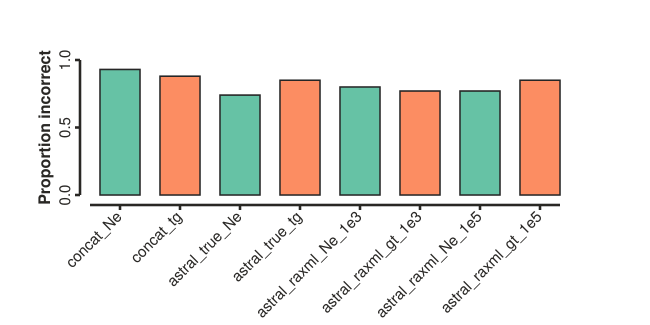

In [434]:
canvas = toyplot.Canvas(width=650, height=325)
axes = canvas.cartesian(bounds=(80, -80, 50, -120))
axes.x.ticks.locator = toyplot.locator.Explicit(np.arange(data_rfg_mci_relax.size) + 0.5, )
axes.x.spine.style["stroke-width"] = 2.5
axes.x.ticks.style["stroke-width"] = 2.5
axes.x.ticks.labels.style["font-size"] = 15
axes.x.label.style["font-size"] = 16
axes.x.domain.min = 0
axes.x.ticks.locator = toyplot.locator.Explicit(
    locations=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
    labels=["concat_Ne", "concat_tg", "astral_true_Ne", "astral_true_tg", "astral_raxml_Ne_1e3", "astral_raxml_gt_1e3", "astral_raxml_Ne_1e5", "astral_raxml_gt_1e5"])
axes.x.ticks.labels.angle = 45

axes.y.label.text = "Proportion incorrect"
axes.y.spine.style["stroke-width"] = 2.5
axes.y.ticks.style["stroke-width"] = 2.5
axes.y.ticks.labels.style["font-size"] = 15
axes.y.ticks.labels.style["font-size"] = 15
axes.y.label.style["font-size"] = 16
axes.y.domain.max = 1.0

starts = np.arange(data_rfg_mci_relax.size) + 1/6
mark = axes.bars(
    starts, 
    starts + 4/6,
    data_rfg_mci_relax,
    style={"stroke": "#262626", 
           "stroke-width": 1.5},
    color=[colors[0], colors[1], colors[0], colors[1], colors[0], colors[1], colors[0], colors[1]]
)

toytree.utils.set_axes_ticks_external(axes);
toyplot.svg.render(canvas, "./nb7_output/astral-error-rate-plot-rfg-mci-absolute.svg")
# toytree.utils.set_axes_box_outline(axes);
canvas

## Gene tree distributions (for balanced tree gene trees)

### Ne, 1e3

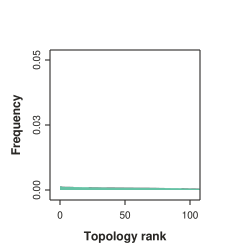

In [435]:
hist = [j for i, j in toytree.mtree(superset_rax_df_ne2_1e3.gene_tree).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear")
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb7_output/genetree_dist_ne2_1e3.svg")
c

### Ne, 1e5

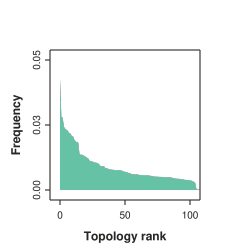

In [436]:
hist = [j for i, j in toytree.mtree(superset_rax_df_ne2_1e5.gene_tree).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear")
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb7_output/genetree_dist_ne2_1e5.svg")
c

### gt, 1e3

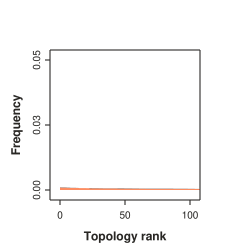

In [437]:
hist = [j for i, j in toytree.mtree(superset_rax_df_gt2_1e3.gene_tree).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear", color=colors[1])
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb7_output/genetree_dist_gt2_1e3.svg")
c

### gt, 1e5

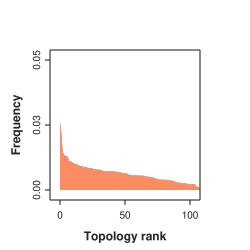

In [438]:
hist = [j for i, j in toytree.mtree(superset_rax_df_gt2_1e5.gene_tree).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear", color=colors[1])
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb7_output/genetree_dist_gt2_1e5.svg")
c

### Unlinked Ne

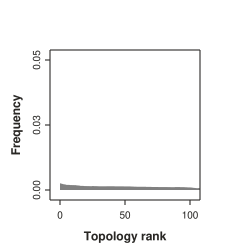

In [439]:
hist = [j for i, j in toytree.mtree(superset_rax_df_true_ne_unlinked.genealogy).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear", color="grey")
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb7_output/true_ne_unlinked.svg")
c

### Unlinked gt

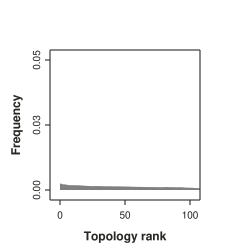

In [440]:
hist = [j for i, j in toytree.mtree(superset_rax_df_true_gt_unlinked.genealogy).get_unique_topologies()]
c, a, m = toyplot.fill(np.array(hist) / sum(hist), height=250, width=250, xmin=1, xmax=100, ymin=0, ymax=0.02, xscale="linear", color="grey")
a.x.label.text = "Topology rank"
a.y.label.text = "Frequency"
toytree.utils.set_axes_ticks_external(a)
toytree.utils.set_axes_box_outline(a)
c.style["stroke.width"]=8
a.y.domain.max=0.05
a.x.domain.max=100
a.y.ticks.locator = toyplot.locator.Uniform(count=3, format='{:.2f}')
toyplot.svg.render(c, "./nb7_output/true_gt_unlinked.svg")
c

In [441]:
superset_rax_df_true_gt_unlinked

Unnamed: 0  locus  start  end  nbps  nsnps  tidx  \
0               0      0      0    1     1      0     0   
1               1      1      0    1     1      0     0   
2               2      2      0    1     1      1     0   
3               3      3      0    1     1      0     0   
4               4      4      0    1     1      0     0   
...           ...    ...    ...  ...   ...    ...   ...   
49995       49995  49995      0    1     1      0     0   
49996       49996  49996      0    1     1      0     0   
49997       49997  49997      0    1     1      0     0   
49998       49998  49998      0    1     1      0     0   
49999       49999  49999      0    1     1      0     0   

                         genealogy  
0      ((r0:754377.276079820934...  
1      ((r0:913433.240321727935...  
2      (r5:2092280.677903639385...  
3      ((r3:763678.299317834200...  
4      (((r4:375696.02116843353...  
...                            ...  
49995  (r3:2007827.653810295974...  
49996  ((r3:675010.797672149026...  
49997  ((r1:1167107.76853239862...  
49998  ((r5:777505.724105048691...  
49999  ((r6:73330.3778440509922...  

[50000 rows x 8 columns]

## POST-ANALYSIS 2: Write test case for toy3 distance module
- See Enum > tests > test_....py for samples
- Format: `unittest.Testcase`

## POST-ANALYSIS 1: Investigating high error rate -> Diagnosed RF Function issue

- RF dist distribution
    - all RF = 0.2 or 0.4
- visualize the inputted gene trees to see how the gene trees are wrong?
    - all seem to be pretty different
    - skewed gene tree topology distribution
- check the inferred astral trees
    - same astral tree inferred as output each time
- give astral all 50,000 gene trees = sample size problem?
    - not a sample size problem, yields same result
- change to quartet metric

### RF function issue in toy3 - AVOID USING FOR NOW

In [20]:
def astral_error(gtrees, correct_tree, gtrees_per_rep, reps):
    """Return error rate of astral inference."""
    # store output
    errors = []
    astral_trees = []
    rfs = []
    # for each replicate
    for i in range(reps):
        # sample 5000 gtrees each time
        sample_gtrees = np.random.choice(gtrees, gtrees_per_rep)
        # infer astral tree based on all inputted gtrees
        astral_tree = ipcoal.phylo.infer_astral_tree(trees = sample_gtrees)
        astral_trees.append(astral_tree.write())
        # check rf dist between astral and correct tree topology
        rf = toytree.distance.get_treedist_rf(astral_tree, correct_tree, normalize=True)
        rfs.append(rf)
        # check if topology is correct or not
        if(rf == 0):
            errors.append(0)
        else:
            errors.append(1)
    error_rate = sum(errors)/len(errors)
    
    # store output as data frame
    pd_data = {'astral_tree': astral_trees, 
               'rf': rfs,
               'error_binary': errors,
              } 
    df_out = pd.DataFrame(data=pd_data)  

    return error_rate, df_out

In [21]:
# test astral_error function
error_rate_test, df_out_test = astral_error(superset_rax_df_ne2_1e3.gene_tree[1:10], baltree_2_ne, 2, 5)

In [22]:
df_out_test

astral_tree   rf  error_binary
0  (r6:1,((r7:1,(r2:1,(r5:1...  0.6             1
1  (r6:1,(r7:1,(r2:1,(r3:1,...  0.8             1
2  (r6:1,((r3:1,(r7:1,r5:1)...  0.8             1
3  (r1:1,((r4:1,(r5:1,(r3:1...  0.8             1
4  (r4:1,((r0:1,(r1:1,r2:1)...  1.0             1

In [23]:
error_rate_test

1.0

### RF dist distribution

In [49]:
datasets = np.array([df_out_ne2_1e5.rf, df_out_gt2_1e5.rf,
                   df_out_ne2_1e3.rf, df_out_gt2_1e3.rf])

In [54]:
canvas = toyplot.Canvas(width=1000, height=400)
names = ["Ne, 1e3", "Ne, 1e5", "gt, 1e3", "gt, 1e5"]
for index, dataset in enumerate(datasets):
    axes = canvas.cartesian(grid=(1, len(datasets), index))
    axes.x.spine.show = False
    axes.x.ticks.labels.show = False
    axes.x.label.text = "Params: {}".format(names[index])
    if index == 0:
        axes.y.show = True
        axes.y.label.text = "RF distance"
    axes.y.domain.min = numpy.min(numpy.concatenate(datasets))
    axes.y.domain.max = numpy.max(numpy.concatenate(datasets))
    counts, bins = numpy.histogram(dataset, 25)
    centers = (bins[:-1] + bins[1:]) / 2
    axes.fill(centers, counts, along="y")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="400.0px" viewBox="0 0 1000.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf16b1e2704b240949ca1523c00720ed8"> <polygon points="50.0,346.99999999999994 50.0,340.99999999999994 50.0,334.99999999999994 50.0,329.0 50.0,323.0 50.0,317.0 50.0,311.0 50.0,305.0 50.0,299.0 50.0,293.0 50.0,287.0 50.0,280.99999999999994 50.0,274.99999999999994 50.0,268.99999999999994 50.0,263.0 50.0,257.0 50.0,250.99999999999997 50.0,244.99999999999997 50.0,239.00000000000003 50.0,233.00000000000003 50.0,227.00000000000003 50.0,221.00000000000003 50.0,215.00000000000003 50.0,209.0 50.0,203.0 182.5,203.0 50.0,209.0 50.0,215.00000000000003 50.0,221.00000000000003 50.0,227.00000000000003 50.0,233.00000000000003 50.0,239.00000000000003 50.0,244.99999999999997 50.0,250.99999999999997 50.0,257.0 50.0,263.0 50.0,268.99999999999994 50.0,274.99999999999994 50.0,280.99999999999994 50.0,287.0 50.0,293.0 50.0,299.0 50.0,305.0 50.0,311.0 50.0,317.0 50.0,323.0 50.0,329.0 50.0,334.99999999999994 50.0,340.99999999999994 167.5,346.99999999999994" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:1.0;stroke:none"> Params: Ne, 1e3 0.2 0.3 0.4 0.5 0.6 RF distance <polygon points="300.0,346.99999999999994 300.0,340.99999999999994 300.0,334.99999999999994 300.0,329.0 300.0,323.0 300.0,317.0 300.0,311.0 300.0,305.0 300.0,299.0 300.0,293.0 300.0,287.0 300.0,280.99999999999994 300.0,274.99999999999994 300.0,268.99999999999994 300.0,263.0 300.0,257.0 300.0,250.99999999999997 300.0,244.99999999999997 300.0,239.00000000000003 300.0,233.00000000000003 300.0,227.00000000000003 300.0,221.00000000000003 300.0,215.00000000000003 300.0,209.0 300.0,203.0 437.5,203.0 300.0,209.0 300.0,215.00000000000003 300.0,221.00000000000003 300.0,227.00000000000003 300.0,233.00000000000003 300.0,239.00000000000003 300.0,244.99999999999997 300.0,250.99999999999997 300.0,257.0 300.0,263.0 300.0,268.99999999999994 300.0,274.99999999999994 300.0,280.99999999999994 300.0,287.0 300.0,293.0 300.0,299.0 300.0,305.0 300.0,311.0 300.0,317.0 300.0,323.0 300.0,329.0 300.0,334.99999999999994 300.0,340.99999999999994 412.5,346.99999999999994" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:1.0;stroke:none"> Params: Ne, 1e5 0.2 0.3 0.4 0.5 0.6 <polygon points="550.0,343.99999999999994 550.0,331.99999999999994 550.0,320.0 550.0,308.0 550.0,296.0 550.0,283.99999999999994 550.0,271.99999999999994 550.0,260.0 550.0,247.99999999999997 550.0,236.00000000000003 550.0,224.00000000000003 550.0,212.0 550.0,199.99999999999997 550.0,187.99999999999994 550.0,175.99999999999994 550.0,164.0 550.0,152.0 550.0,139.99999999999997 550.0,127.99999999999997 550.0,115.99999999999997 550.0,103.99999999999994 550.0,91.99999999999994 550.0,79.99999999999993 550.0,67.99999999999991 550.0,55.9999999999999 552.4999999999999,55.9999999999999 550.0,67.99999999999991 550.0,79.99999999999993 550.0,91.99999999999994 550.0,103.99999999999994 550.0,115.99999999999997 550.0,127.99999999999997 550.0,139.99999999999997 550.0,152.0 550.0,164.0 550.0,175.99999999999994 550.0,187.99999999999994 682.5,199.99999999999997 550.0,212.0 550.0,224.00000000000003 550.0,236.00000000000003 550.0,247.99999999999997 550.0,260.0 550.0,271.99999999999994 550.0,283.99999999999994 550.0,296.0 550.0,308.0 550.0,320.0 550.0,331.99999999999994 665.0,343.99999999999994" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:1.0;stroke:none"> Params: gt, 1e3 0.2 0.3 0.4 0.5 0.6 <polygon points="800.0,343.99999999999994 800.0,331.99999999999994 800.0,320.0 800.0,308.0 800.0,296.0 800.0,283.99999999999994 800.0,271.9999999999999

### Visualize gene trees

In [134]:
toytree.tree(superset_rax_df_ne2_1e3.gene_tree[15]).draw();

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta8bfd4bdd9db48988caa65099d44aeb8"> r0 r6 r1 r3 r4 r7 r2 r5

In [63]:
gt2_1e5_gtree_mtree = toytree.mtree(superset_rax_df_gt2_1e5.gene_tree)

In [64]:
gt2_1e5_gtree_mtree.draw(shape=(5,5));

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="750.0px" height="750.0px" viewBox="0 0 750.0 750.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t55cc86b3f6ea447aa7202fef590333f8"> r7 r6 r3 r4 r5 r0 r1 r2 r1 r0 r3 r5 r4 r6 r7 r2 r7 r6 r2 r1 r0 r3 r4 r5 r2 r6 r4 r7 r3 r0 r1 r5 r4 r5 r7 r3 r2 r0 r1 r6 r7 r4 r5 r3 r0 r1 r2 r6 r0 r1 r2 r7 r3 r6 r5 r4 r5 r6 r2 r7 r3 r4 r0 r1 r4 r5 r3 r2 r0 r1 r7 r6 r4 r5 r3 r2 r1 r0 r6 r7 r5 r7 r2 r6 r3 r0 r1 r4 r0 r1 r6 r7 r4 r5 r3 r2 r3 r2 r7 r5 r4 r0 r1 r6 r7 r2 r6 r5 r4 r3 r0 r1 r0 r1 r7 r3 r5 r4 r6 r2 r2 r7 r6 r3 r5 r4 r1 r0 r2 r3 r6 r1 r0 r7 r4 r5 r0 r7 r2 r6 r5 r4 r3 r1 r0 r1 r7 r5 r4 r2 r3 r6 r2 r1 r0 r3 r7 r5 r4 r6 r0 r1 r7 r5 r4 r3 r6 r2 r2 r6 r1 r0 r3 r5 r4 r7 r5 r4 r3 r2 r1 r0 r7 r6 r3 r2 r5 r4 r7 r1 r0 r6 r3 r7 r6 r2 r1 r0 r5 r4

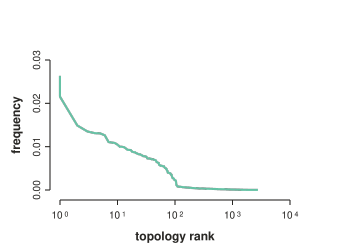

In [69]:
# inferred gene tree topology
hist = [j for i, j in gt2_1e5_gtree_mtree.get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

### Check inferred ASTRAL trees

In [65]:
gt2_1e5_astral_mtree = toytree.mtree(df_out_gt2_1e5.astral_tree)

In [66]:
gt2_1e5_astral_mtree.draw(shape=(5,5));

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="750.0px" height="750.0px" viewBox="0 0 750.0 750.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t33c749bcfc884565af596ca7518f14c5"> r5 r7 r6 r3 r2 r1 r0 r4 r7 r6 r5 r4 r3 r2 r1 r0 r1 r0 r7 r6 r4 r5 r2 r3 r0 r3 r2 r7 r6 r4 r5 r1 r0 r3 r2 r5 r4 r6 r7 r1 r5 r7 r6 r0 r1 r2 r3 r4 r1 r2 r3 r5 r4 r7 r6 r0 r0 r3 r2 r7 r6 r5 r4 r1 r4 r7 r6 r3 r2 r1 r0 r5 r4 r5 r1 r0 r3 r2 r6 r7 r3 r2 r0 r1 r4 r5 r6 r7 r6 r7 r4 r5 r0 r1 r2 r3 r1 r3 r2 r5 r4 r6 r7 r0 r3 r2 r0 r1 r5 r4 r6 r7 r6 r5 r4 r0 r1 r3 r2 r7 r1 r3 r2 r5 r4 r7 r6 r0 r0 r3 r2 r4 r5 r7 r6 r1 r0 r2 r3 r6 r7 r4 r5 r1 r6 r7 r0 r1 r3 r2 r4 r5 r3 r0 r1 r6 r7 r4 r5 r2 r2 r3 r5 r4 r7 r6 r0 r1 r1 r2 r3 r7 r6 r5 r4 r0 r4 r7 r6 r2 r3 r0 r1 r5 r4 r6 r7 r2 r3 r0 r1 r5 r3 r2 r0 r1 r5 r4 r6 r7

In [71]:
gt2_1e5_astral_mtree.get_unique_topologies()

[[<toytree.ToyTree at 0x7f66d67a42d0>, 100]]

In [72]:
gt2_1e5_astral_mtree.all_tree_topologies_same()

True

### Possible sample size problem? Give ASTRAL all 50,000 gene trees to infer

In [73]:
error_rate_gt2_1e5_50000gtrees, df_out_gt2_1e5_50000gtrees = astral_error(superset_rax_df_gt2_1e5.gene_tree, baltree_2_gt, 50000, 100)

In [74]:
error_rate_gt2_1e5_50000gtrees

1.0

In [75]:
df_out_gt2_1e5_50000gtrees

astral_tree   rf  error_binary
0   (r7:1,(r6:1,((r5:1,r4:1)...  0.2             1
1   (r4:1,(((r6:1,r7:1)1:0.0...  0.2             1
2   (r2:1,(r3:1,(((r7:1,r6:1...  0.4             1
3   (r7:1,(r6:1,((r4:1,r5:1)...  0.2             1
4   (r7:1,(((r5:1,r4:1)1:1.8...  0.2             1
..                          ...  ...           ...
95  (r6:1,(r7:1,((r5:1,r4:1)...  0.2             1
96  (r0:1,(((r2:1,r3:1)1:0.0...  0.4             1
97  (r3:1,(r2:1,(((r4:1,r5:1...  0.4             1
98  (r5:1,(((r7:1,r6:1)1:0.0...  0.2             1
99  (r6:1,(r7:1,(((r2:1,r3:1...  0.2             1

[100 rows x 3 columns]

In [78]:
gt2_1e5_50000gtrees_astral_mtree = toytree.mtree(df_out_gt2_1e5_50000gtrees.astral_tree)

In [79]:
gt2_1e5_50000gtrees_astral_mtree.all_tree_topologies_same()

True

In [81]:
gt2_1e5_50000gtrees_astral_mtree.draw();

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="750.0px" height="250.0px" viewBox="0 0 750.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb4f250d575dc4027985de5c7c9ceb9bf"> r7 r6 r5 r4 r1 r0 r2 r3 r4 r6 r7 r1 r0 r3 r2 r5 r2 r3 r7 r6 r5 r4 r1 r0 r7 r6 r4 r5 r3 r2 r0 r1

### Change to different distance metrics

### Quartets

In [14]:
def astral_error_qrt(gtrees, correct_tree, gtrees_per_rep, reps):
    """Return error rate of astral inference."""
    # store output
    errors = []
    astral_trees = []
    qrts = []
    # for each replicate
    for i in range(reps):
        # sample 5000 gtrees each time
        sample_gtrees = np.random.choice(gtrees, gtrees_per_rep)
        # infer astral tree based on all inputted gtrees
        astral_tree = ipcoal.phylo.infer_astral_tree(trees = sample_gtrees)
        astral_trees.append(astral_tree.write())
        # check quartet (do not conflict) dist between astral and correct tree topology
        qrt = toytree.distance.get_treedist_quartets(astral_tree, correct_tree)[8]
        qrts.append(qrt)
        # check if topology is correct or not
        if(qrt == 0):
            errors.append(0)
        else:
            errors.append(1)
    error_rate = sum(errors)/len(errors)
    
    # store output as data frame
    pd_data = {'astral_tree': astral_trees, 
               'qrt': qrts,
               'error_binary': errors,
              } 
    df_out = pd.DataFrame(data=pd_data)  

    return error_rate, df_out

In [9]:
# test quartets function
toytree.distance.get_treedist_quartets(toytree.tree(superset_rax_df_gt2_1e5.gene_tree[1]), baltree_2_gt)

Q                              70.000000
S                              39.000000
D                              31.000000
U                               0.000000
R1                              0.000000
R2                              0.000000
N                              70.000000
do_not_conflict                 0.442857
explicitly_agree                0.442857
strict_joint_assertions         0.442857
semistrict_joint_assertions     0.442857
steel_and_penny                 0.442857
symmetric_difference            0.442857
symmetric_divergence            0.114286
similarity_to_reference         0.442857
marczewski_steinhaus            0.613861
dtype: float64

In [16]:
error_rate_gt2_1e5_qrt, df_out_gt2_1e5_qrt = astral_error_qrt(superset_rax_df_gt2_1e5.gene_tree, baltree_2_gt, 5000, 100)

In [17]:
error_rate_gt2_1e5_qrt

0.0

In [18]:
df_out_gt2_1e5_qrt.to_csv("./nb7_output/astral_error_df_out_gt2_1e5_qrt.csv")

In [19]:
df_out_gt2_1e5_qrt

astral_tree  qrt  error_binary
0   (r1:1,(((r3:1,r2:1)1:0.0...  0.0             0
1   (r3:1,(((r1:1,r0:1)1:1.8...  0.0             0
2   (r7:1,(r6:1,((r4:1,r5:1)...  0.0             0
3   (r0:1,(((r2:1,r3:1)1:0.0...  0.0             0
4   (r0:1,(((r2:1,r3:1)1:0.0...  0.0             0
..                          ...  ...           ...
95  (r6:1,(r7:1,(((r2:1,r3:1...  0.0             0
96  (r5:1,(((r7:1,r6:1)1:0.0...  0.0             0
97  (r0:1,(r1:1,((r3:1,r2:1)...  0.0             0
98  (r1:1,(((r2:1,r3:1)1:0.0...  0.0             0
99  (r0:1,(r1:1,((r2:1,r3:1)...  0.0             0

[100 rows x 3 columns]

### RFG-MCI

In [43]:
def astral_error_rfg_mci(gtrees, correct_tree, gtrees_per_rep, reps):
    """Return error rate of astral inference."""
    # store output
    errors = []
    astral_trees = []
    rfg_mcis = []
    # for each replicate
    for i in range(reps):
        # sample 5000 gtrees each time
        sample_gtrees = np.random.choice(gtrees, gtrees_per_rep)
        # infer astral tree based on all inputted gtrees
        astral_tree = ipcoal.phylo.infer_astral_tree(trees = sample_gtrees)
        astral_trees.append(astral_tree.write())
        # check quartet (do not conflict) dist between astral and correct tree topology
        rfg_mci = toytree.distance.get_treedist_rfg_mci(astral_tree, correct_tree)
        rfg_mcis.append(rfg_mci)
        # check if topology is correct or not
        if(rfg_mci == 0):
            errors.append(0)
        else:
            errors.append(1)
    error_rate = sum(errors)/len(errors)
    
    # store output as data frame
    pd_data = {'astral_tree': astral_trees, 
               'rfg_mci': rfg_mcis,
               'error_binary': errors,
              } 
    df_out = pd.DataFrame(data=pd_data)  

    return error_rate, df_out

In [44]:
error_rate_gt2_1e5_rfg_mci, df_out_gt2_1e5_rfg_mci = astral_error_rfg_mci(superset_rax_df_gt2_1e5.gene_tree, baltree_2_gt, 5000, 100)

In [45]:
error_rate_gt2_1e5_rfg_mci

0.87

In [46]:
df_out_gt2_1e5_rfg_mci.to_csv("./nb7_output/astral_error_df_out_gt2_1e5_rfg_mci.csv")

In [47]:
df_out_gt2_1e5_rfg_mci

astral_tree       rfg_mci  error_binary
0   (r7:1,(r6:1,((r5:1,r4:1)...  1.776357e-15             1
1   (r1:1,(((r3:1,r2:1)1:0.0...  1.776357e-15             1
2   (r3:1,(r2:1,(((r4:1,r5:1...  0.000000e+00             0
3   (r2:1,(r3:1,((r0:1,r1:1)...  1.776357e-15             1
4   (r0:1,(((r3:1,r2:1)1:0.0...  1.776357e-15             1
..                          ...           ...           ...
95  (r0:1,(((r2:1,r3:1)1:0.0...  1.776357e-15             1
96  (r0:1,(((r3:1,r2:1)1:0.0...  1.776357e-15             1
97  (r5:1,(((r7:1,r6:1)1:0.0...  1.776357e-15             1
98  (r3:1,(r2:1,(((r4:1,r5:1...  0.000000e+00             0
99  (r0:1,(((r3:1,r2:1)1:0.0...  1.776357e-15             1

[100 rows x 3 columns]